# Install Package

In [3]:
!pip install streamlit==1.14.0
!pip install --no-cache-dir --upgrade tweepy
!pip install gensim
!pip install pyngrok
!pip install joblib
!pip install contractions
!pip install pyspellchecker
!pip install fasttext
!pip install tomotopy
!pip install altair
!pip install -U scikit-learn
!pip install scikeras
!pip install tensorflow_text
!pip install --upgrade scipy
!pip install --upgrade numba 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 6.3 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=9844f966dfa127f33c3a54f2b3a095e9c36495d0acf58fc6f9d4706ce0782af8
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb7

# Loading Model

In [15]:
import time
import nltk
import fasttext
import tensorflow as tf
from nltk.tag import HunposTagger

start = time.time()
print("1/3 Loading Model")
nltk.download('stopwords')
print("2/3 Loading Model")
nltk.download('punkt')
print("3/3 Loading Model")
nltk.download('averaged_perceptron_tagger')
def load_model():
  print("1/2 Loading Model")
  detect_lang = fasttext.load_model(CWD + "model/lid.176.ftz")
  print("2/2 Loading Model")
  word2vec = tf.keras.models.load_model(CWD + 'model/word2vec_en.tf')
  return detect_lang, word2vec 

detect_lang, word2vec = load_model()
hpt = HunposTagger(path_to_model = CWD + 'model/hunpos-1.0-linux/english.model', path_to_bin = CWD + 'model/hunpos-1.0-linux/hunpos-tag')

print(time.time() - start)

1/3 Loading Model
2/3 Loading Model
3/3 Loading Model
1/2 Loading Model
2/2 Loading Model


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
2023-01-13 01:25:57.529 WARNING tensorflow: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


1.7395060062408447


# Common Function

In [16]:
import tweepy
import joblib
import html
import re
import contractions
import string
import nltk
import fasttext 
import time
import pandas as pd
import tomotopy as tp
import streamlit as st
import numpy as np
import altair as alt
import joblib
import tensorflow as tf
import gensim.corpora.dictionary as Dictionary
import gensim.models.tfidfmodel as TfidfModel

from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from nltk.collocations import *

SEPARATOR = "<new_tweet>"
CHART_WIDTH = 702
CHART_HEIGHT = 395
PRODUCT_REVIEW = "product_review_3"
SENTIMENT = "sentiment4"
DEBUG = False

#####################Wrapper function#####################
def detect_lang_wrap(tweet):
  if not pd.isna(tweet):
    return detect_lang.predict(tweet)[0][0]
  return np.nan

def html_escape_helper(tweet):
  if not pd.isna(tweet): #html escape does not accept nan
    return html.unescape(tweet)
  else:
    return tweet

def noun_only(x):
  # https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2
  filtered = [word[0] for word in x if word[1] in [b'NN', 'NN']]
  return ' '.join(filtered)  

def bigram_filter(bigram):
    stop_word_list = stopwords.words('english')
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

def replace_ngram(x, bigrams):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(['_'] + gram.split() + ['_']))
    return x

def return_topic(x, topic):
  if not pd.isna(x):
    return topic[int(x)]


#####################Replace function#####################
def replace(series, action, parameter = None):
  
  #1. standardize
  series = series.replace("", np.nan)
  series = series.apply(str)
  series = series.str.strip()
  saved_index = series.index
  passage = series.str.cat(sep = " " + SEPARATOR + " ", na_rep = '') #ignore nan + it must " <new_tweet> " at least once
  passage = re.sub(r"\s+", " ", passage)
  
  #2. action
  passage = action(passage, parameter) 

  #3. split back into row
  output = pd.Series(passage.split(SEPARATOR))
  output = output.str.strip()
  output = output.replace("nan", np.nan)
  output.index = saved_index
  return output

def fix_cannot(passage, parameter):
  return re.sub("cannot", "not", passage)

def fix_contractions(passage, parameter):
  return contractions.fix(passage)

def get_unique_token_from_string(passage, parameter):
  return list(Counter(passage.split(" ")).keys())

def stop_word(passage, parameter):  
  #1. Build dictionary
  vocab = get_unique_token_from_string(passage, parameter)
  stop_words = stopwords.words('english') 
  stop_words.remove("no")
  stop_words.remove("not")
  stop_words.remove("nor")

  #2. Remove
  stop_words = Counter(stop_words) #Speed up next line
  passage = [word for word in passage.split(" ") if word not in stop_words] #str.split(" ") and str.split() are different
  passage = ' '.join(passage)
  return passage

def unknown_word(passage, parameter):
  #1. Build dictionary
  vocab = get_unique_token_from_string(passage, parameter)
  spell = SpellChecker()
  misspelled = spell.unknown(vocab)
  if "nan" in misspelled:
    misspelled.remove("nan")
  misspelled.remove(SEPARATOR) 

  #2. Remove
  misspelled = Counter(misspelled) #Speed up next line
  passage = [word for word in passage.split(" ") if word not in misspelled] #str.split(" ") and str.split() are different
  passage = ' '.join(passage)
  return passage

def remove_not(passage, parameter):
  remove_word = Counter(["no", "not", "nor"])
  passage = [word for word in passage.split(" ") if word not in remove_word] #str.split(" ") and str.split() are different
  passage = ' '.join(passage)
  return passage

def reduce_redundancy(passage, parameter):
  
  #1. Build dictionary
  word_counter = Counter(passage.split(" "))
  word = list(word_counter.keys())

  #2. Generating word vector
  word_vector_main = word2vec_vector(word)
  df_word = {}
  for i in range(0, len(word)):
    word_vector = word_vector_main[i][0]
    if not np.all(word_vector == 0):
      df_word[word[i]] = word_vector
  df_word = pd.DataFrame.from_dict(df_word, orient = "index")

  #3. Get clustering of each word
  clustering = AgglomerativeClustering(distance_threshold = parameter["synonym"], n_clusters  = None, metric = "cosine", linkage = "complete").fit(df_word)
  df_word = df_word.join(pd.Series(clustering.labels_, index = df_word.index ,name = "Clusters"))
  df_word = df_word.join(pd.DataFrame.from_dict(word_counter, orient = "index", columns = ["sum_tfidf"]))

  #4. Label cluster with max tfidf
  n_clusters = max(df_word.Clusters) + 1
  cluster_label = {}

  test = df_word.sort_values(by = ["Clusters", "sum_tfidf"], ascending = [True, False])
  test = test.drop_duplicates(subset = "Clusters", keep = "first")

  for i in range(0, len(test["Clusters"])):
    cluster_label[test["Clusters"][i]] = test.index[i]

  df_word['cluster_label'] = df_word['Clusters'].replace(cluster_label)

  df_word = df_word.reset_index()
  dictionary = {}
  for i in range(0, df_word.shape[0]):
    dictionary[df_word.at[i,"index"]] = df_word.at[i,"cluster_label"]

  #5. Replacing word with synonyms
  dictionary['<new_tweet>'] = '<new_tweet>'
  dictionary[''] = ''
  passage =  ' '.join([dictionary[word] for word in passage.split(" ") if word in dictionary.keys()])

  df_word[["index", "Clusters", "sum_tfidf", 'cluster_label']].to_csv(CWD + "data/df_word.csv")
  return passage

def out_of_vocabulary(passage, parameter):

  #1. Built vocabulary
  vocab = parameter["vocab"]
  word_counter = Counter(passage.split(" "))
  current_vocab = list(word_counter.keys())
  current_vocab.remove(SEPARATOR)
  word = current_vocab + list(vocab)

  #2. Generating word vector
  word_vector_main = word2vec_vector(word)
  df_word = {}
  for i in range(0, len(word)):
    word_vector = word_vector_main[i][0]
    if not np.all(word_vector == 0):
      df_word[word[i]] = word_vector
  df_word = pd.DataFrame.from_dict(df_word, orient = "index")

  #3. Generating Distance matrix and Get nearest word
  dist_mat = pd.DataFrame(cosine_distances(df_word), columns = df_word.index, index = df_word.index)
  dist_mat = dist_mat[current_vocab]
  dist_mat = dist_mat.loc[vocab]

  dist_mat[dist_mat > parameter["synonym"]] = np.nan
  dictionary = pd.DataFrame(dist_mat.idxmin(), columns = ["svm_word"])
  dictionary["svm_word"] = dictionary["svm_word"].replace(np.nan, "")
  convert = {}
  for i in range(0, dictionary.shape[0]):
    convert[dictionary.index[i]] = dictionary.iloc[i]['svm_word']

  #4. Replacing word with synonyms
  convert['<new_tweet>'] = '<new_tweet>'
  convert[''] = ''
  passage =  ' '.join([convert[word] for word in passage.split(" ") if word in convert.keys()])
  return passage
  
def stemming(passage, parameter):
  #1. Build dictionary
  vocab = get_unique_token_from_string(passage, parameter)
  term = pd.DataFrame({"index": vocab, "stem" :vocab})
  stemmer = PorterStemmer()
  term["stem"] = term["stem"].apply(stemmer.stem)
  term["len"] = [len(i) for i in term["index"]]

  #2. Repair Stem
  test = term.sort_values(by = ["stem", "len"])
  test = test.drop_duplicates(subset = "stem", keep = "first")
  test = test.reset_index(drop = True)
  dictionary = {}
  for i in range(0, test.shape[0]):
    dictionary[test.at[i,"stem"]] = test.at[i,"index"]
  term['stem'] = [dictionary[word] for word in term['stem']]
  dictionary = {}
  for i in range(0, term.shape[0]):
    dictionary[term.at[i,"index"]] = term.at[i,"stem"]
    
  #3. Stemming
  dictionary['<new_tweet>'] = '<new_tweet>'
  dictionary[''] = ''
  return ' '.join([dictionary[word] for word in passage.split(" ") if word in dictionary.keys()])

#####################Core function#####################
def fetch_tweet(search_query, debug = False):
  start = time.time()
  if debug:
    df = pd.read_csv(CWD + "data/1.data.csv")
    df = df.rename(columns = {"tweet": "text"})
    df[PRODUCT_REVIEW] = df[PRODUCT_REVIEW].replace({"Product Review" : 1, "Not Product Review": 0})
    df[SENTIMENT] = df[SENTIMENT].replace({"Positive emotion" : 2, "No emotion toward brand or product": 1, "Negative emotion": 0})
  else:
    query = search_query + " -is:retweet lang:en"
    client = tweepy.Client(BEARER_TOKEN, return_type = dict)
    tweet_dict = tweepy.Paginator(client.search_recent_tweets, query = query, max_results = 100).flatten(limit = 1000)
    df = pd.DataFrame([tweet for tweet in tweet_dict])
  print("0. Fetch Tweet: ", time.time() - start)
  return df

def text_cleaning(series):

  start = time.time()

  ##Fix encoding, remove formatting and non-ASCII character
  series = series.str.encode("utf-8")
  series = series.str.decode("utf-8") 
  series = series.apply(html_escape_helper)
  series = series.str.replace("\n", "", regex = False)
  series = series.str.replace(r'[^\x00-\x7F]+', " ", regex = True)
  
  ##Remove tweet character
  series = series.str.replace(r"RT @\w+", "", regex = True)
  series = series.str.replace(r"via @\w+", "", regex = True)
  series = series.str.replace(r"RT", "", regex = False)
  series = series.str.replace(r"@mention", "", regex = False)
  series = series.str.replace(r'\w*\d\w*', "", regex = True)

  ##Remove URL
  series = series.str.replace(r"{link}", "", regex = False)
  series = series.str.replace(r"http\S+", "", regex = True)
  series = series.str.replace(r"(bit.ly)\S+", "", regex = True)

  print("1. Text Cleaning: ", time.time() - start)

  return series.copy()

def text_preprocessing(series):

  table = {'!': ' ', '"': ' ', '#': '', '$': ' ', '%': ' ', '&': ' ', "'": ' ', '(': ' ', ')': ' ', '*': ' ', '+': ' ', ',': ' ', '-': '', '.': ' ', '/': ' or ', 
        ':': ' ', ';': ' ', '<': ' ', '=': ' ', '>': ' ', '?': ' ', '@': ' ', '[': ' ', '\\': ' ', ']': ' ', '^': ' ', '_': '', '`': ' ', '{': ' ', '|': ' ', 
        '}': ' ', '~': ' '}
      
  start = time.time()
  #Lower case
  series = series.str.lower()

  #Fix contraction
  series = series.str.replace(r"'s", "", regex = False)
  series = replace(series, fix_contractions)

  #Remove punctuation (This must be the last step)
  series = series.str.translate(str.maketrans(table))
  
  #Remove non English Tweet
  temp = pd.concat([series, series.apply(detect_lang_wrap)], axis = 1)
  temp.columns = ["cleaned_tweet", "lang"]
  temp.loc[temp['lang'] != "__label__en", "cleaned_tweet"] = np.nan 

  #Get noun
  temp["noun"] = temp["cleaned_tweet"].replace("", np.nan)
  temp["noun"] = temp["noun"].apply(str)
  temp["noun"] = temp["noun"].str.strip()
  temp["noun"] = temp["noun"].str.replace(r"\s+", " ", regex = True)
  temp["noun"] = temp["noun"].str.split(" ")
  temp["noun"] = temp["noun"].apply(hpt.tag)
  temp["noun"] = temp["noun"].apply(noun_only)

  #Remove unknown word spelling and stopword 
  temp['cleaned_tweet'] = replace(temp['cleaned_tweet'], stop_word) 
  temp['cleaned_tweet'] = replace(temp['cleaned_tweet'], unknown_word)

  print("2. Text preprocessing: ", time.time() - start)

  return temp["noun"], temp['cleaned_tweet']

def cleanup(series):
  start = time.time()

  series = replace(series, fix_cannot) 
  series = series.str.replace(r"\s+", " ", regex = True)
  series = series.str.strip()

  print("3. Cleanup: ", time.time() - start)

  return series

def assign_pr(df, model, vocab, predict_proba = False):

  start = time.time()
  df['pr_tweet'] = replace(df['cleaned_tweet'], out_of_vocabulary, {"vocab": vocab, "synonym": 0.38})
  
  vectorizer = TfidfVectorizer()
  X = vectorizer.fit_transform(df["pr_tweet"]).toarray()
  X = pd.DataFrame(X, columns = vectorizer.get_feature_names_out())
  not_in_X = [i for i in vocab if i not in X.columns]
  not_in_X = pd.DataFrame(np.zeros((X.shape[0], len(not_in_X))), columns = [i for i in vocab if i not in X.columns])
  X = pd.concat([X, not_in_X], axis = 1 )
  X = X.groupby(X.columns, axis = 1).agg(sum)
  X = X[vocab]
  if predict_proba:
    if type(model).__name__ in ["SVC"]:
      df[PRODUCT_REVIEW] = model.decision_function(X)
    elif type(model).__name__ == "SGDClassifier":
      if model.loss == "hinge":
        df[PRODUCT_REVIEW] = model.decision_function(X)
      else:
        df[PRODUCT_REVIEW] = model.predict_proba(X)[:,1]
    else:
      df[PRODUCT_REVIEW] = model.predict_proba(X)[:,1]
  else:
      df[PRODUCT_REVIEW] = model.predict(X)
  print("3. Assign Review: ", time.time() - start)
  return df.copy()

def assign_sentiment(df, model, predict_proba = False):
  start = time.time()
  Y = model.predict(df['cleaned_tweet'], verbose = 0)
  print("3. Assign Sentiment: ", time.time() - start)
  if predict_proba:
    return Y
  else:  
    Y = [np.argmax(i) for i in Y]
    df[SENTIMENT] = Y
    return df.copy()

def assign_topic(X, model, test = False):
  start = time.time()
  #detect bigram
  bigram_measures = nltk.collocations.BigramAssocMeasures()
  finder = BigramCollocationFinder.from_documents([str(i).split() for i in X])
  finder.apply_freq_filter(7)
  if finder.score_ngrams(bigram_measures.pmi) != []: #This mean no ngram found
    bigram_list, scores = zip(*finder.score_ngrams(bigram_measures.pmi))
    bigram_list = finder.score_ngrams(bigram_measures.pmi)
    bigrams = [' '.join(i[0]) for i in bigram_list if bigram_filter(i[0]) if i[1] > 2]
    X = X.apply(replace_ngram, args = (bigrams,))
  
  #model
  text_obj = tp.utils.Corpus()
  texts = [text_obj.add_doc(str(i).split()) for i in X]
  mdl = model(tw = tp.TermWeight.IDF, k = 10, corpus = text_obj, seed = 42)
  mdl.burn_in = 100
  mdl.train(1000)
  
  #convert mdl.used_vocab to dict
  used_vocabs = {}
  for i in range(0, len(mdl.used_vocabs)):
    used_vocabs[mdl.used_vocabs[i]] = i

  #build topic-term matrix
  topic_word_df = pd.DataFrame(columns = mdl.used_vocabs)
  for i in range(mdl.k):
    topic_word_df = topic_word_df.append(pd.Series(mdl.get_topic_word_dist(topic_id = i), index = mdl.used_vocabs), ignore_index = True)

  #tf-idf ranking
  vectorizer = TfidfVectorizer(vocabulary = used_vocabs)
  vectorizer.fit(X)
  idf = pd.Series(vectorizer.idf_, vectorizer.get_feature_names_out())
  topic_word_df_out = topic_word_df.mul(idf, axis = 1)

  #Labelling
  topics_for_coherence = []
  topics_for_inference = []
  for k in range(mdl.k): 
    topic_word = topic_word_df_out.iloc[k].copy()
    topics_for_coherence.append(list(topic_word[~np.isinf(topic_word)].sort_values(ascending = False).index[0:10]))
    topics_for_inference.append(topic_word[~np.isinf(topic_word)].sort_values(ascending = False).index[0])
  
  #Inference
  vectorizer = CountVectorizer(vocabulary = used_vocabs)
  noun_count = pd.DataFrame(vectorizer.fit_transform(X).toarray(), columns = vectorizer.get_feature_names_out())
  noun_count.index = X.index
  noun_count = noun_count.where(noun_count <= 1, 1)
  pseudo_prob = np.matmul(noun_count, np.asarray(topic_word_df_out.transpose()))
  pseudo_prob = pseudo_prob.div(pseudo_prob.sum(axis = 1), axis = 0)
  y = pseudo_prob.idxmax(axis = 1).apply(return_topic, args = (topics_for_inference, ))

  #coherence
  if test:
    texts = [str(i).split() for i in X]
    dictionary  = Dictionary(texts)
    corpus = [dictionary.doc2bow(i) for i in texts]
    model_tfidf = TfidfModel(corpus)
    corpus = [model_tfidf[i] for i in corpus]
    cm1 = CoherenceModel(topics = topics_for_coherence, texts = texts, corpus = corpus, dictionary = dictionary, coherence='c_v')
    print(cm1.get_coherence())
  print("4. Assign Topic: ", time.time() - start)
  return y

# Obtaining Data

0. Fetch Tweet:  0.07783174514770508


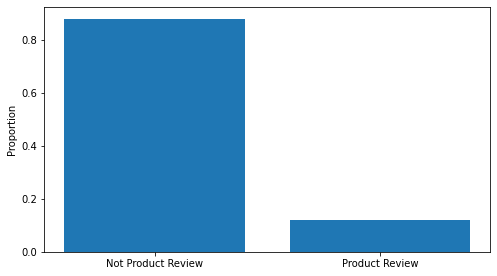

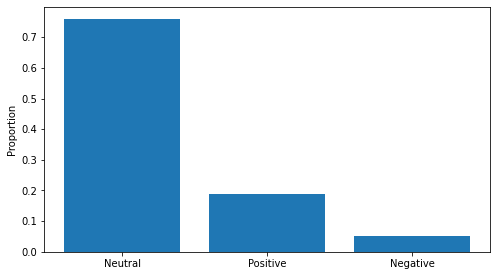

In [17]:
import matplotlib.pyplot as plt
df = fetch_tweet("iphone", debug = True)

# https://stackoverflow.com/questions/36004976/count-frequency-of-values-in-pandas-dataframe-column
pr = df[PRODUCT_REVIEW].value_counts().to_dict()
st = df[SENTIMENT].value_counts().to_dict()

# https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
plt.figure(figsize = (8, 4.5))
plt.bar(["Not Product Review", "Product Review"], [round(i / sum(pr.values()),2) for i in list(pr.values())])
plt.ylabel("Proportion")
plt.show()

plt.figure(figsize = (8, 4.5))
plt.bar(["Neutral", "Positive", "Negative"], [round(i / sum(st.values()),2) for i in list(st.values())])
plt.ylabel("Proportion")
plt.show()

# Scrubbing Data

In [18]:
from sklearn.model_selection import train_test_split


df["cleaned_tweet"] = text_cleaning(df["text"])
df["noun"], df["cleaned_tweet"] = text_preprocessing(df["cleaned_tweet"])
df["cleaned_tweet"] = cleanup(df["cleaned_tweet"])
df = df[pd.isna(df['cleaned_tweet']) == False].copy()
df = df[df['cleaned_tweet'] != ""].copy()
df = df.drop_duplicates(subset = ['cleaned_tweet'])

df_preprocessed_train, df_preprocessed_test = train_test_split(df, test_size=0.20, random_state = 42)

print(df.shape)
print(df_preprocessed_train.shape)
print(df_preprocessed_test.shape)


1. Text Cleaning:  0.21885108947753906
2. Text preprocessing:  5.82636284828186
3. Cleanup:  0.0778205394744873
(6753, 6)
(5402, 6)
(1351, 6)


# Exploring Data

## Word Cloud

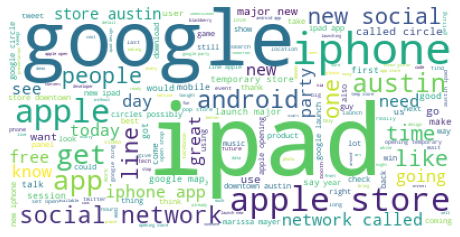

In [ ]:
from wordcloud import WordCloud
stop_words = stopwords.words('english')

# https://www.geeksforgeeks.org/generating-word-cloud-python/#:~:text=For%20generating%20word%20cloud%20in,from%20UCI%20Machine%20Learning%20Repository.
comment_words = df_preprocessed_train['cleaned_tweet'].str.cat(sep = "", na_rep = '') 
wordcloud = WordCloud(background_color ='white',stopwords = stop_words).generate(comment_words)

plt.figure(figsize = (8, 4.5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Reduce Redundancy

In [ ]:
def word2vec_vector(word):
  vectorizer = word2vec.get_layer(index = 0)
  embedding = word2vec.get_layer(index = 1)
  return embedding(vectorizer(word)).numpy()

In [ ]:
df_train_preprocessed_noredundancy = df_preprocessed_train.copy()
df_train_preprocessed_noredundancy['cleaned_tweet'] = replace(df_train_preprocessed_noredundancy['cleaned_tweet'] , reduce_redundancy, {"synonym": 0.38})
print("Before Dimensionality Reduction: " + str(len(set(df_preprocessed_train['cleaned_tweet'].str.cat(sep = "", na_rep = '').split()))))
print("After Dimensionality Reduction: " + str(len(set(df_train_preprocessed_noredundancy['cleaned_tweet'].str.cat(sep = "", na_rep = '').split()))))

Before Dimensionality Reduction: 10043
After Dimensionality Reduction: 8745


## Reduce Irrelevancy

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

vectorizer = TfidfVectorizer()
df_train_preprocessed_noredundancy = df_train_preprocessed_noredundancy[pd.isna(df_train_preprocessed_noredundancy['cleaned_tweet']) == False].copy()
df_train_preprocessed_noredundancy = df_train_preprocessed_noredundancy[df_train_preprocessed_noredundancy['cleaned_tweet'] != ""].copy()
df_train_preprocessed_noredundancy = df_train_preprocessed_noredundancy.drop_duplicates(subset = ['cleaned_tweet'])
X = pd.DataFrame(vectorizer.fit_transform(df_train_preprocessed_noredundancy['cleaned_tweet']).toarray(), 
                                                           columns = vectorizer.get_feature_names_out(), 
                                                           index = df_train_preprocessed_noredundancy.index)
y = df_train_preprocessed_noredundancy[PRODUCT_REVIEW].astype("int64")


class_weight = compute_class_weight(class_weight = "balanced", classes = np.unique(df_train_preprocessed_noredundancy[PRODUCT_REVIEW]),  y = df_train_preprocessed_noredundancy[PRODUCT_REVIEW])
class_weight = {0: class_weight[0], 1: class_weight[1]}
clf = ExtraTreesClassifier(criterion = "entropy", random_state = 42, class_weight = class_weight)
clf = clf.fit(X, y)
selector = SelectFromModel(clf, prefit=True)
feature = pd.DataFrame(pd.Series(clf.feature_importances_, index = X.columns))
feature["selected"] = pd.Series(selector.get_support(), index = X.columns)
feature = feature.reset_index()
selectedfeature = feature[feature["selected"] == True].sort_values(by = 0, ascending = False)
print("After Feature Selection: " + str(selectedfeature.shape[0]))

After Feature Selection: 912


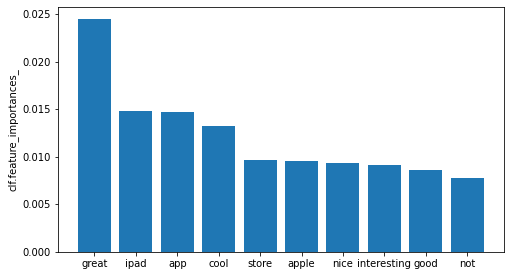

In [ ]:
plt.figure(figsize = (8, 4.5))
plt.bar(selectedfeature["index"][0:10], selectedfeature[0][0:10])
plt.ylabel("clf.feature_importances_")
plt.show()

In [ ]:
np.savetxt(SAVED_TO + "data/feature.csv", np.reshape(selectedfeature["index"].to_numpy(),(-1, 6)), fmt = "%s")

# Modelling Data

## Product Review

### Prepare Data

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


vectorizer = TfidfVectorizer()
X = df_train_preprocessed_noredundancy['cleaned_tweet']
X = pd.DataFrame(vectorizer.fit_transform(X).toarray(), 
                 columns = vectorizer.get_feature_names_out(), 
                 index = X.index)
X = X[selectedfeature["index"]]
X = X.join(df_train_preprocessed_noredundancy['cleaned_tweet'])
y = df_train_preprocessed_noredundancy[PRODUCT_REVIEW].astype("int64")

#Train validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state = 42)
X_train = X_train.drop('cleaned_tweet', axis = 1)

#Set class weight
class_weight = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train),  y = y_train)
class_weight = {0: class_weight[0], 1: class_weight[1]}
  


### Build Model

In [ ]:
def get_model():
    NI = len(selectedfeature["index"])
    HIDDEN_LAYER_UNIT = round((2 / 3) * NI + 3)
    model =tf.keras.Sequential([
        tf.keras.Input(shape = (NI, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(HIDDEN_LAYER_UNIT, activation='relu'),
        tf.keras.layers.Dense(HIDDEN_LAYER_UNIT, activation='relu'),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(optimizer="adam",loss='binary_crossentropy', weighted_metrics=[tf.keras.metrics.AUC(from_logits=True, name = "auc")])
    return model

model_pr = {"NB":BaggingClassifier(ComplementNB()), 
"LR": BaggingClassifier(SGDClassifier(loss = "log_loss", class_weight = class_weight, early_stopping = True)), 
"DT": HistGradientBoostingClassifier(loss = "log_loss", class_weight = class_weight),
"SVM": SVC(class_weight = class_weight), 
"MLP": AdaBoostClassifier(KerasClassifier(model=get_model, epochs = 10, 
                                          validation_split = 0.1, 
                                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor = "val_auc", patience = 1)], 
                                          class_weight = class_weight), n_estimators = 10, random_state = 42),
"kNN":BaggingClassifier(KNeighborsClassifier())}

### Train Model

In [ ]:
metric = {"NB": [], "LR": [], "DT": [], "SVM": [], "MLP": [], "kNN": []}
for m in model_pr.keys():
  model = model_pr[m]
  model.fit(X_train, y_train)
  prediction = assign_pr(pd.DataFrame(X_val["cleaned_tweet"]), model, vocab = X_train.columns, predict_proba = True)
  acc = roc_auc_score(y_val, prediction[PRODUCT_REVIEW])
  metric[m].append(round(acc,4))
print(metric)


3. Assign Review:  1.7507984638214111
3. Assign Review:  1.399094581604004
3. Assign Review:  0.6665761470794678
3. Assign Review:  3.05218243598938
Epoch 1/10
122/122 [==============================] - 5s 28ms/step - loss: 1.5858e-04 - auc: 0.6280 - val_loss: 1.5813e-04 - val_auc: 0.7807
Epoch 2/10
122/122 [==============================] - 3s 24ms/step - loss: 1.3994e-04 - auc: 0.7920 - val_loss: 1.4003e-04 - val_auc: 0.8342
Epoch 3/10
122/122 [==============================] - 3s 24ms/step - loss: 1.0414e-04 - auc: 0.8768 - val_loss: 1.1932e-04 - val_auc: 0.8383
Epoch 4/10
135/135 [==============================] - 1s 5ms/step
Epoch 1/10
122/122 [==============================] - 4s 23ms/step - loss: 1.9659e-04 - auc: 0.5625 - val_loss: 3.7438e-04 - val_auc: 0.6117
Epoch 2/10
122/122 [==============================] - 3s 22ms/step - loss: 1.7810e-04 - auc: 0.6858 - val_loss: 3.9556e-04 - val_auc: 0.6350
Epoch 3/10
122/122 [==============================] - 3s 23ms/step - loss: 1.681

### Save Model

In [ ]:
import joblib
joblib.dump(model_pr["LR"], SAVED_TO + "model/model_pr_new.sav")

['/content/drive/MyDrive/main/model/model_pr_new.sav']

## Topic Modelling

### Prepare Data

In [ ]:
# https://radimrehurek.com/gensim/models/ldamodel.html 
df_preprocessed_tp_train, df_preprocessed_tp_validation = train_test_split(df_preprocessed_train, test_size=0.20, random_state = 42)
df_preprocessed_tp_train['noun'] = replace(df_preprocessed_tp_train['noun'], stop_word)
df_preprocessed_tp_train['noun'] = replace(df_preprocessed_tp_train['noun'], remove_not)
df_preprocessed_tp_train['noun'] = replace(df_preprocessed_tp_train['noun'], unknown_word)
df_preprocessed_tp_train['noun'] = replace(df_preprocessed_tp_train['noun'], stemming)
df_preprocessed_tp_train['noun'] = replace(df_preprocessed_tp_train['noun'], reduce_redundancy, {"synonym": 0.20})
df_preprocessed_tp_train = df_preprocessed_tp_train[pd.isna(df_preprocessed_tp_train['noun']) == False].copy()
df_preprocessed_tp_train = df_preprocessed_tp_train[df_preprocessed_tp_train['noun'] != ""].copy()
df_preprocessed_tp_train = df_preprocessed_tp_train.drop_duplicates(subset = ['noun'])
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents([str(i).split() for i in df_preprocessed_tp_train['noun']])
finder.apply_freq_filter(10)
if finder.score_ngrams(bigram_measures.pmi) != []: #This mean no ngram found
  bigram_list, scores = zip(*finder.score_ngrams(bigram_measures.pmi))
  bigram_list = finder.score_ngrams(bigram_measures.pmi)
  bigrams = [' '.join(i[0]) for i in bigram_list if bigram_filter(i[0]) if i[1] > 3]
  df_preprocessed_tp_train['noun'] = df_preprocessed_tp_train['noun'].apply(replace_ngram, args = (bigrams,))

text_obj = tp.utils.Corpus()
texts = [text_obj.add_doc(str(i).split()) for i in df_preprocessed_tp_train['noun']]

### Build Model

In [ ]:
#LDA
mdl1 = tp.LDAModel(tw = tp.TermWeight.IDF, k = 10, corpus = text_obj, seed = 42)

#PTM
mdl2 = tp.PTModel(tw = tp.TermWeight.IDF, k = 10, corpus = text_obj, seed = 42)

### Train Model

In [ ]:
#LDA
start = time.time()
mdl1.burn_in = 100
mdl1.train(1000, workers = 1)
print(time.time() - start)

#PTM
start = time.time()
mdl2.burn_in = 100
mdl2.train(1000, workers = 1)
print(time.time() - start)

2.267461061477661
15.135926246643066


In [ ]:
def reweigting_topic_term_matrix(model):
  #model = mdl1
  used_vocabs = {}
  for i in range(0, len(model.used_vocabs)):
    used_vocabs[model.used_vocabs[i]] = i

  #build topic-term matrix
  topic_word_df = pd.DataFrame(columns = model.used_vocabs)
  for i in range(model.k):
    topic_word_df = topic_word_df.append(pd.Series(model.get_topic_word_dist(topic_id = i), index = model.used_vocabs), ignore_index = True)

  #tf-idf ranking
  vectorizer = TfidfVectorizer(vocabulary = used_vocabs)
  vectorizer.fit(df_preprocessed_tp_train['noun'])
  idf = pd.Series(vectorizer.idf_, vectorizer.get_feature_names_out())
  topic_word_df_out = topic_word_df.mul(idf, axis = 1)

  #Labelling
  topics = []
  for k in range(model.k): 
    topic_word = topic_word_df_out.iloc[k].copy()
    topics.append(list(topic_word[~np.isinf(topic_word)].sort_values(ascending = False).index[0:10]))
  return topics


In [ ]:
topic_LDA = reweigting_topic_term_matrix(mdl1)
topic_PTM = reweigting_topic_term_matrix(mdl2)

[['service',
  'app',
  'platform',
  'lot',
  'relief',
  'facebook',
  'week',
  'ipad',
  'twitter',
  'killer'],
 ['design',
  '__brain_search__',
  'lounge',
  'party',
  'e',
  'blogger',
  'interface',
  'talk',
  'calendar',
  'touch'],
 ['news',
  'schedule',
  'network',
  'game',
  'app',
  'music',
  'android',
  'go',
  'site',
  'google'],
 ['access',
  'room',
  'session',
  'user',
  'discovery',
  'route',
  'tattoo',
  'traffic',
  'use',
  'reality'],
 ['__apple_store__',
  'line',
  'apple',
  'austin',
  '__downtown_austin__',
  'pop',
  'launch',
  '__store_congress__',
  'ipad',
  'release'],
 ['blackberry',
  'something',
  'anyone',
  'apple',
  '__apple_store__',
  'crowd',
  'tablet',
  'stock',
  'demo',
  'door'],
 ['card',
  'web',
  'blog',
  'version',
  'bing',
  'post',
  'brand',
  'google',
  'read',
  'watch'],
 ['mom',
  'cannot',
  'life',
  'guy',
  '__music_sampler__',
  'lol',
  'ipad',
  'apple',
  'company',
  'place'],
 ['present',
  'showca

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

texts = [str(i).split() for i in df_preprocessed_tp_train['noun']]
dictionary  = Dictionary(texts)
corpus = [dictionary.doc2bow(i) for i in texts]
model_tfidf = TfidfModel(corpus)
corpus = [model_tfidf[i] for i in corpus]

cm1 = CoherenceModel(topics = topic_LDA, texts = texts, corpus = corpus, dictionary = dictionary, coherence='c_v')
print(cm1.get_coherence())

cm2 = CoherenceModel(topics = topic_PTM, texts = texts, corpus = corpus, dictionary = dictionary, coherence='c_v')
print(cm2.get_coherence())

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English
2023-01-10 02:32:43.395 INFO    summarizer.preprocessing.cleaner: 'pattern' package not found; tag filters are not available for English
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
2023-01-10 02:32:43.418 INFO    gensim.corpora.dictionary: adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(1987 unique tokens: ['earth', 'access', 'account', 'day', 'iphone']...) from 3448 documents (total 11972 corpus positions)
2023-01-10 02:32:43.458 INFO    gensim.corpora.dictionary: built Dictionary(1987 unique tokens: ['earth', 'access', 'account', 'day', 'iphone']...) from 3448 documents (total 11972 corpus positions)
INFO:gensim.models.tfidfmodel:collecting document frequencies
2023-01-10 02:32:43.483 INFO    gensim.models.tfidfmodel: collecting document frequencies
INFO:gensim.models.tfidfmodel:PROG

0.3890509279576937
0.5022869808137079


## Sentiment Classification

### Prepare Data

In [ ]:
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(42)
num_class = 3
#Split into train and validation
df_train_preprocessed_noredundancy_train, df_train_preprocessed_noredundancy_val = train_test_split(df_train_preprocessed_noredundancy, test_size=0.20, random_state = 42)
X_train, y_train = df_train_preprocessed_noredundancy_train["cleaned_tweet"], df_train_preprocessed_noredundancy_train[SENTIMENT]

#Prepare validation data
X_val, y_val = df_train_preprocessed_noredundancy_val["cleaned_tweet"], df_train_preprocessed_noredundancy_val[SENTIMENT]

#Dummy code
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

#To_numpy() tensorflow only want this
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()

model_st = {}

In [ ]:
def init_imbalanced_class_weight_bias(df:pd.DataFrame, label:str):
  from scipy.optimize import fsolve
  from math import exp

  # to deal with imbalance classification, calculate class_weight 
  d = dict(df[label].value_counts())
  m = np.mean(list(d.values()))
  class_weight = {k:m/v for (k,v) in d.items()} #e.g. {0: 1.6282051282051282, 1: 0.7604790419161677, 2: 0.9338235294117647}
  
  # define classes frequency list
  frequency = list(list(d.values())/sum(d.values()))

  # define equations to solve initial bias
  def eqn(x, frequency=frequency):
      sum_exp = sum([exp(x_i) for x_i in x])
      return [exp(x[i])/sum_exp - frequency[i] for i in range(len(frequency))]

  # calculate init bias
  bias_init = fsolve(func=eqn,
                    x0=[0]*len(frequency),
                    ).tolist()

  return class_weight, bias_init 

class_weight, bias_init = init_imbalanced_class_weight_bias(df=df_train_preprocessed_noredundancy_val, label=SENTIMENT)
bias_init

[1.2635426544240453, -0.0632320166702152, -1.2003105861661363]

### Build Model

In [ ]:
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
EMBEDDING_DIM = 300

#Built Model
start = time.time()
embeddings_index = {}
f = open(CWD + "model/word2vec.en.txt", 'r', encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(time.time() - start)

vectorizer = tf.keras.layers.TextVectorization(vocabulary = list(embeddings_index.keys()))
word_index = vectorizer.get_vocabulary()
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for i in range(0, len(word_index)):
    embedding_vector = embeddings_index.get(word_index[i])
    if embedding_vector is not None and len(embedding_vector) == EMBEDDING_DIM:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

LSTM_UNIT = 128
HIDDEN_LAYER_UNIT = round((2 / 3) * LSTM_UNIT + 3)
model = tf.keras.Sequential([
    tf.keras.layers.TextVectorization(vocabulary = list(embeddings_index.keys())),
    tf.keras.layers.Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False),
    tf.keras.layers.LSTM(LSTM_UNIT), 
    tf.keras.layers.Dense(HIDDEN_LAYER_UNIT, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_UNIT, activation='relu'),
    tf.keras.layers.Dense(num_class, activation='softmax', bias_initializer = tf.keras.initializers.Constant(bias_init))
])
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=[tf.keras.metrics.AUC(from_logits=True, multi_label = True, name = "auc")])


Found 152986 word vectors.
15.266351461410522


In [ ]:
#https://towardsdatascience.com/sentiment-analysis-using-lstm-and-glove-embeddings-99223a87fe8e
import tensorflow_text as text
import tensorflow_hub as hub


bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=False)
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/2", trainable=False)
GRU_unit = 128
HIDDEN_LAYER_UNIT = round((2 / 3) * GRU_unit + 3)

# https://www.analyticsvidhya.com/blog/2021/12/text-classification-using-bert-and-tensorflow/
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  preprocessed_text = bert_preprocess_model(text_input)
  outputs = bert_encoder(preprocessed_text)
  gru = tf.keras.layers.GRU(GRU_unit)(outputs["sequence_output"])
  mlp1 = tf.keras.layers.Dense(HIDDEN_LAYER_UNIT, activation='relu')(gru)
  mlp2 = tf.keras.layers.Dense(HIDDEN_LAYER_UNIT, activation='relu')(mlp1)
  net = tf.keras.layers.Dense(num_class, activation='softmax', bias_initializer = tf.keras.initializers.Constant(bias_init))(mlp2)
  return tf.keras.Model(text_input, net)

model2 = build_classifier_model()
model2.compile(optimizer="adam",loss='categorical_crossentropy',metrics=[tf.keras.metrics.AUC(from_logits=True, multi_label = True, name = "auc")])


2023-01-10 01:48:41.087 WARNING tensorflow: Please fix your imports. Module tensorflow.python.training.tracking.data_structures has been moved to tensorflow.python.trackable.data_structures. The old module will be deleted in version 2.11.
INFO:absl:Using /tmp/tfhub_modules to cache modules.
2023-01-10 01:48:41.101 INFO    absl: Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
2023-01-10 01:48:41.113 INFO    absl: Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
2023-01-10 01:48:41.225 INFO    absl: Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
2023-01-10 01:48:41.230 INFO    absl: Downloaded TF-Hub Module 'https://tfhub.dev/t

### Train Model

In [ ]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(monitor = "val_auc", patience = 1)], class_weight = class_weight)

Epoch 1/10
135/135 [==============================] - 49s 243ms/step - loss: 1.0447 - auc: 0.5715 - val_loss: 0.9751 - val_auc: 0.6664
Epoch 2/10
135/135 [==============================] - 29s 216ms/step - loss: 0.8325 - auc: 0.7349 - val_loss: 0.9450 - val_auc: 0.8039
Epoch 3/10
135/135 [==============================] - 35s 261ms/step - loss: 0.6718 - auc: 0.8436 - val_loss: 0.6039 - val_auc: 0.8710
Epoch 4/10
135/135 [==============================] - 30s 224ms/step - loss: 0.5627 - auc: 0.8891 - val_loss: 0.8472 - val_auc: 0.8568


In [ ]:
model2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(monitor = "val_auc", patience = 1)], class_weight = class_weight)

Epoch 1/10
135/135 [==============================] - 521s 4s/step - loss: 0.9901 - auc: 0.6517 - val_loss: 1.1386 - val_auc: 0.7549
Epoch 2/10
135/135 [==============================] - 414s 3s/step - loss: 0.8433 - auc: 0.7683 - val_loss: 1.1238 - val_auc: 0.7863
Epoch 3/10
135/135 [==============================] - 419s 3s/step - loss: 0.7901 - auc: 0.7950 - val_loss: 0.9426 - val_auc: 0.7985
Epoch 4/10
135/135 [==============================] - 422s 3s/step - loss: 0.7231 - auc: 0.8301 - val_loss: 1.0228 - val_auc: 0.7889


In [ ]:
model_st["WE_LSTM"] = model
model_st["BERT_GRU"] = model2

### Save Model

In [ ]:
model_st["WE_LSTM"].save(SAVED_TO + "model/model_st_new.tf", include_optimizer = False)

2023-01-10 02:59:30.196 WARNING absl: Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses while saving (showing 2 of 2). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/main/model/model_st_new.tf/assets
2023-01-10 02:59:32.821 INFO    tensorflow: Assets written to: /content/drive/MyDrive/main/model/model_st_new.tf/assets


# Interpreting Data

In [ ]:
##Wait until last minutes
df_test = df_preprocessed_test.copy()
df_test['cleaned_tweet'] = replace(df_test['cleaned_tweet'], reduce_redundancy, {"synonym": 0.20})

,ID,text,sentiment4,product_review_3,cleaned_tweet,noun
8555,8130,2100+ #SXSW artists categorized alphabetically...,1,0,artists categorized alphabetically easy access...,sxsw access google spreadsheet
1992,7772,Awesome! RT @mention Yes! Gowalla wins best An...,2,1,awesome yes wins best app team android choice ...,gowalla app team choice sxsw
2334,2227,Marissa Mayer: 40% Of Google Maps Usage Is Mob...,1,0,mayer google maps usage mobile million mobile ...,marissa mayer usage
6861,4496,3:45 am and I just put the word &quot;food&quo...,1,0,put word food google maps search phone yeah,word food phone sxsw
3461,4340,#Thanks @mention we're lovin' the @mention app...,2,1,thanks loving app update iphone sure download ...,app iphone
...,...,...,...,...,...,...
1738,4705,Wow. I'm not spending a minute more at #SXSW i...,1,0,wow not spending minute line apple store,minute sxsw line apple popup store sxsw
1726,3407,"In less than 24 hours, this will be an Apple S...",1,0,less hours apple store line,apple store line sxsw
7080,1588,Woot! RT @mention First Android @mention disc ...,2,0,first android disc market version coming soon,disc market version
2602,3472,"@mention Hey Eric, it was at a pop-up Apple st...",1,0,hey eric apple store nice long line folks read...,apple store line


## Product Review

In [ ]:
y_val = df_test[PRODUCT_REVIEW].to_numpy()
metric_pr = {}
vocab = model_pr["SVM"].feature_names_in_
for m in model_pr.keys():
    prediction = assign_pr(pd.DataFrame(df_test["cleaned_tweet"]), model_pr[m], vocab = vocab, predict_proba = True)
    acc = roc_auc_score(y_val, prediction[PRODUCT_REVIEW])
    metric_pr[m] = acc
metric_pr

3. Assign Review:  1.6965014934539795
3. Assign Review:  0.987431526184082
3. Assign Review:  0.95729660987854
3. Assign Review:  3.867527723312378
43/43 [==============================] - 0s 5ms/step
3. Assign Review:  5.929764747619629
3. Assign Review:  4.550231218338013


{'NB': 0.7706480923462057,
 'LR': 0.8277664456909739,
 'DT': 0.7590885911640629,
 'SVM': 0.8202841778313474,
 'MLP': 0.8054355384544065,
 'kNN': 0.6160516434101341}

## Topic Model

In [ ]:
df_test['noun'] = replace(df_test['noun'], stop_word)
df_test['noun'] = replace(df_test['noun'], remove_not)
df_test['noun'] = replace(df_test['noun'], unknown_word)
df_test['noun'] = replace(df_test['noun'], stemming)
df_test['noun'] = replace(df_test['noun'], reduce_redundancy, {"synonym": 0.20})
df_test = df_test[pd.isna(df_test['noun']) == False].copy()
df_test = df_test[df['noun'] != ""].copy()
df_test = df_test.drop_duplicates(subset = ['noun'])

assign_topic(df_test['noun'], tp.LDAModel, test = True)
assign_topic(df_test['noun'], tp.PTModel, test = True)

<ipython-input-94-155d3f634a80>:409: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  mdl.train(1000)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
2023-01-10 02:57:54.033 INFO    gensim.corpora.dictionary: adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(1104 unique tokens: ['access', 'google', 'spreadsheet', 'app', 'choice']...) from 1163 documents (total 3874 corpus positions)
2023-01-10 02:57:54.067 INFO    gensim.corpora.dictionary: built Dictionary(1104 unique tokens: ['access', 'google', 'spreadsheet', 'app', 'choice']...) from 1163 documents (total 3874 corpus positions)
INFO:gensim.models.tfidfmodel:collecting document frequencies
2023-01-10 02:57:54.093 INFO    gensim.models.tfidfmodel: collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
2023-01-10 02:57:54.109 INFO    gensim.models.tfidfmodel: PROGRESS:

0.43186974346548934
4. Assign Topic:  1.9160165786743164


8555              party
1992              party
2334               home
6861                guy
3461                app
             ...       
8759    __apple_store__
2651           platform
1738    __apple_store__
7080              power
5930               home
Length: 1163, dtype: object

## Sentiment Model

In [ ]:
y_val = df_test[SENTIMENT].to_numpy()
y_val = to_categorical(y_val)
metric_st = {}
for m in model_st.keys():
  prediction = assign_sentiment(pd.DataFrame(df_test["cleaned_tweet"]), model_st[m], predict_proba = True)
  acc = roc_auc_score(y_val, prediction, average = "macro")
  metric_st[m] = acc
metric_st  

3. Assign Sentiment:  12.945579290390015
3. Assign Sentiment:  145.13704633712769


{'WE_LSTM': 0.8491192134405695, 'BERT_GRU': 0.7800763076765591}